In [27]:
# ANALYSE CHURN - FREEBOX REVOLUTION

import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, RocCurveDisplay

%matplotlib inline
sns.set_theme(style="whitegrid")

In [30]:
# 1. CHARGEMENT DES DONNÉ

DATA_PATH = r'C:\Users\youce\Desktop\Cas pratique\fake_liste_users_revo_130122.yaml'

with open(DATA_PATH, 'r') as f:
    df = pd.DataFrame(yaml.load(f, Loader=yaml.FullLoader))

print(f"Nombre d'utilisateurs : {len(df)}")
df.head(3)

Nombre d'utilisateurs : 20000


,acquisition_channel,cancel_year_month,duration_month,fiber_or_adsl,has_retention,offer,recruit_year_month,sub_offer,total_bill
0,phone,2019-07,42,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01,11.4:Freebox Revolution with TV 3999eur,1810
1,online,2018-07,18,adsl,False,#11:Freebox Revolution with TV 3999eur,2017-01,11.4:Freebox Revolution with TV 3999eur,670
2,phone,2018-03,26,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01,11.4:Freebox Revolution with TV 3999eur,1030


In [34]:
# 2. NETTOYAGE

# Date de souscription
df['recruit_date'] = pd.to_datetime(df['recruit_year_month'], format='%Y-%m')

# Churné ou non (cancel_year_month = 'N/A' si encore actif)
df['churned'] = df['cancel_year_month'] != 'N/A'

# Cohorte = année de souscription
df['cohort'] = df['recruit_date'].dt.year.astype(str)

# Durée : fournie si churné, sinon on calcule jusqu'au 13/01/2022
OBSERVATION_DATE = pd.Timestamp('2022-01-13')
df['duration'] = df.apply(
    lambda r: r['duration_month'] if r['churned']
    else (OBSERVATION_DATE.year - r['recruit_date'].year) * 12
         + (OBSERVATION_DATE.month - r['recruit_date'].month),
    axis=1
)
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

print(df[['cohort', 'churned', 'duration', 'fiber_or_adsl', 'has_retention']].head())

  cohort  churned  duration fiber_or_adsl  has_retention
0   2016     True        42          adsl          False
1   2017     True        18          adsl          False
2   2016     True        26          adsl          False
3   2017    False        60         fiber          False
4   2016     True        37          adsl          False


In [39]:
# 3. CHURN — Q1 : Taille des cohortes

print(df.groupby('cohort').size().rename('n_users'))
print(f"\nActifs en janvier 2022 : {(~df['churned']).sum()} ({(~df['churned']).mean()*100:.1f}%)")

cohort
2016    10452
2017     9548
Name: n_users, dtype: int64

Actifs en janvier 2022 : 6569 (32.8%)


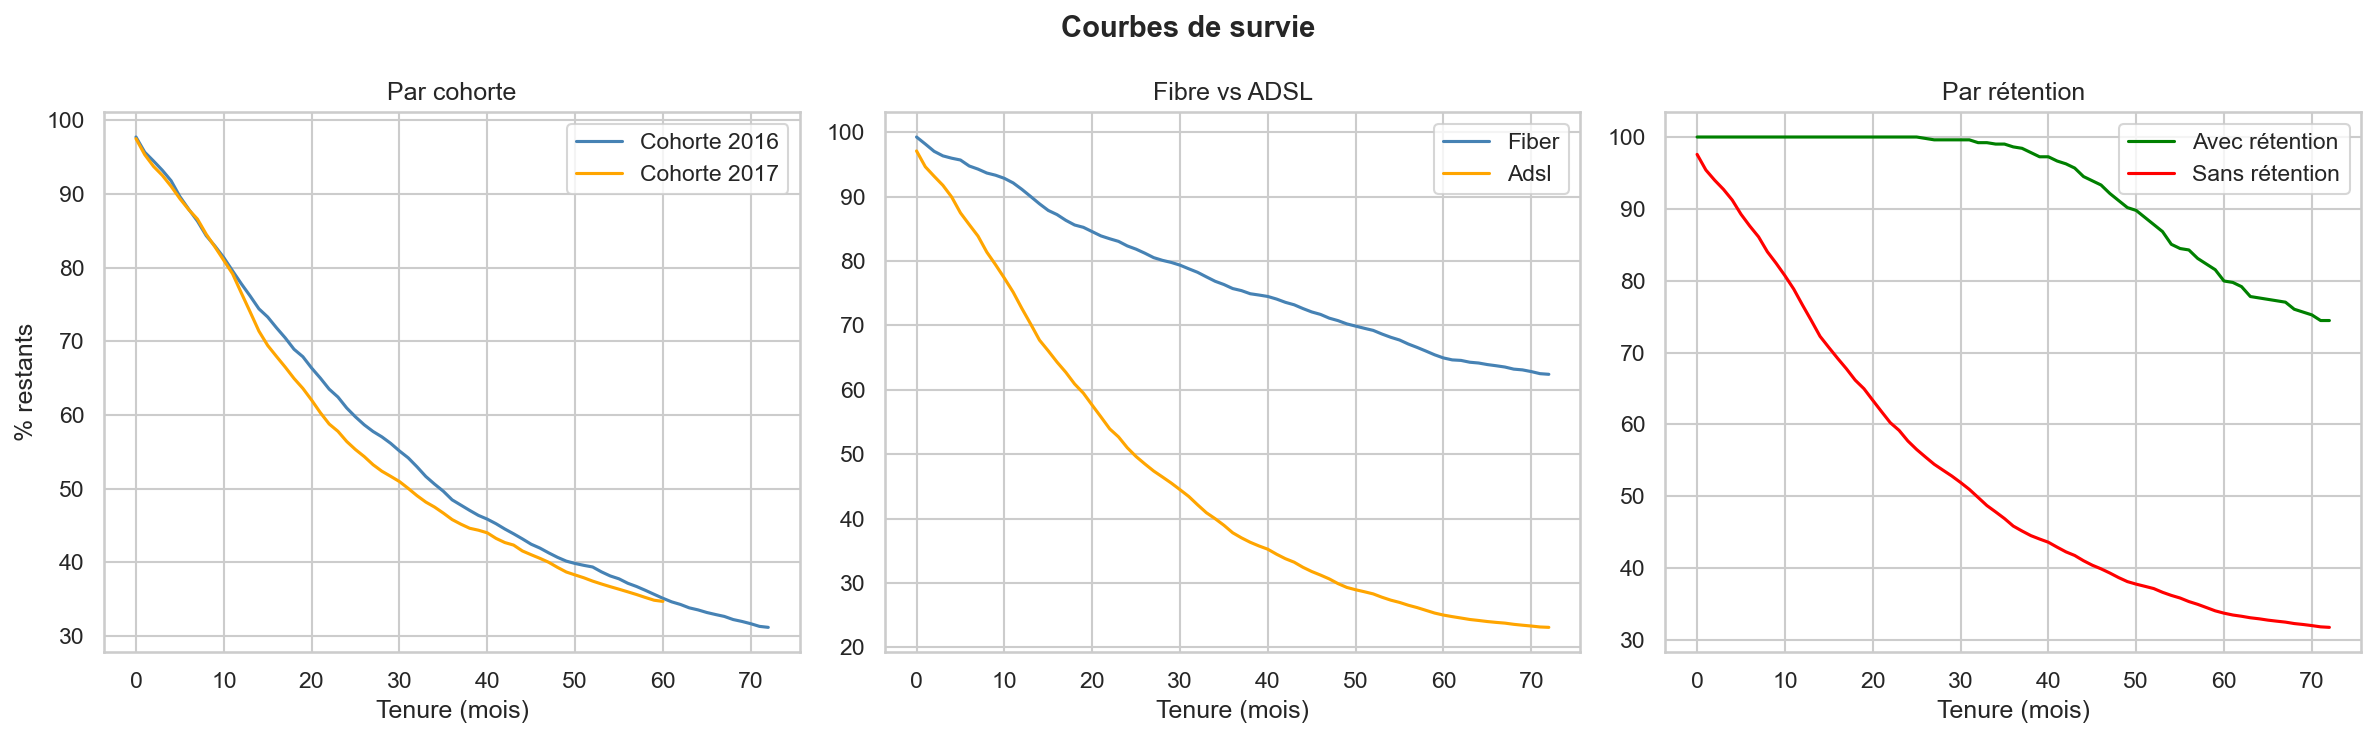

In [38]:
# 4. CHURN — Q2 : Courbe de survie

def survival_curve(sub_df):
    """Calcule la % d'utilisateurs encore présents à chaque mois de tenure."""
    n = len(sub_df)
    max_t = int(sub_df['duration'].max())
    return pd.DataFrame([{
        'tenure': t,
        'pct': ((~sub_df['churned']) | (sub_df['duration'] > t)).sum() / n * 100
    } for t in range(max_t + 1)])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Courbes de survie", fontsize=14, fontweight='bold')

# Par cohorte
for cohort, color in [('2016', 'steelblue'), ('2017', 'orange')]:
    s = survival_curve(df[df['cohort'] == cohort])
    axes[0].plot(s['tenure'], s['pct'], label=f'Cohorte {cohort}', color=color)
axes[0].set(title='Par cohorte', xlabel='Tenure (mois)', ylabel='% restants')
axes[0].legend()

# Par type de connexion
for conn, color in [('fiber', 'steelblue'), ('adsl', 'orange')]:
    s = survival_curve(df[df['fiber_or_adsl'] == conn])
    axes[1].plot(s['tenure'], s['pct'], label=conn.capitalize(), color=color)
axes[1].set(title='Fibre vs ADSL', xlabel='Tenure (mois)')
axes[1].legend()

# Par rétention
for ret, label, color in [(True, 'Avec rétention', 'green'), (False, 'Sans rétention', 'red')]:
    s = survival_curve(df[df['has_retention'] == ret])
    axes[2].plot(s['tenure'], s['pct'], label=label, color=color)
axes[2].set(title='Par rétention', xlabel='Tenure (mois)')
axes[2].legend()

plt.tight_layout()
plt.show()

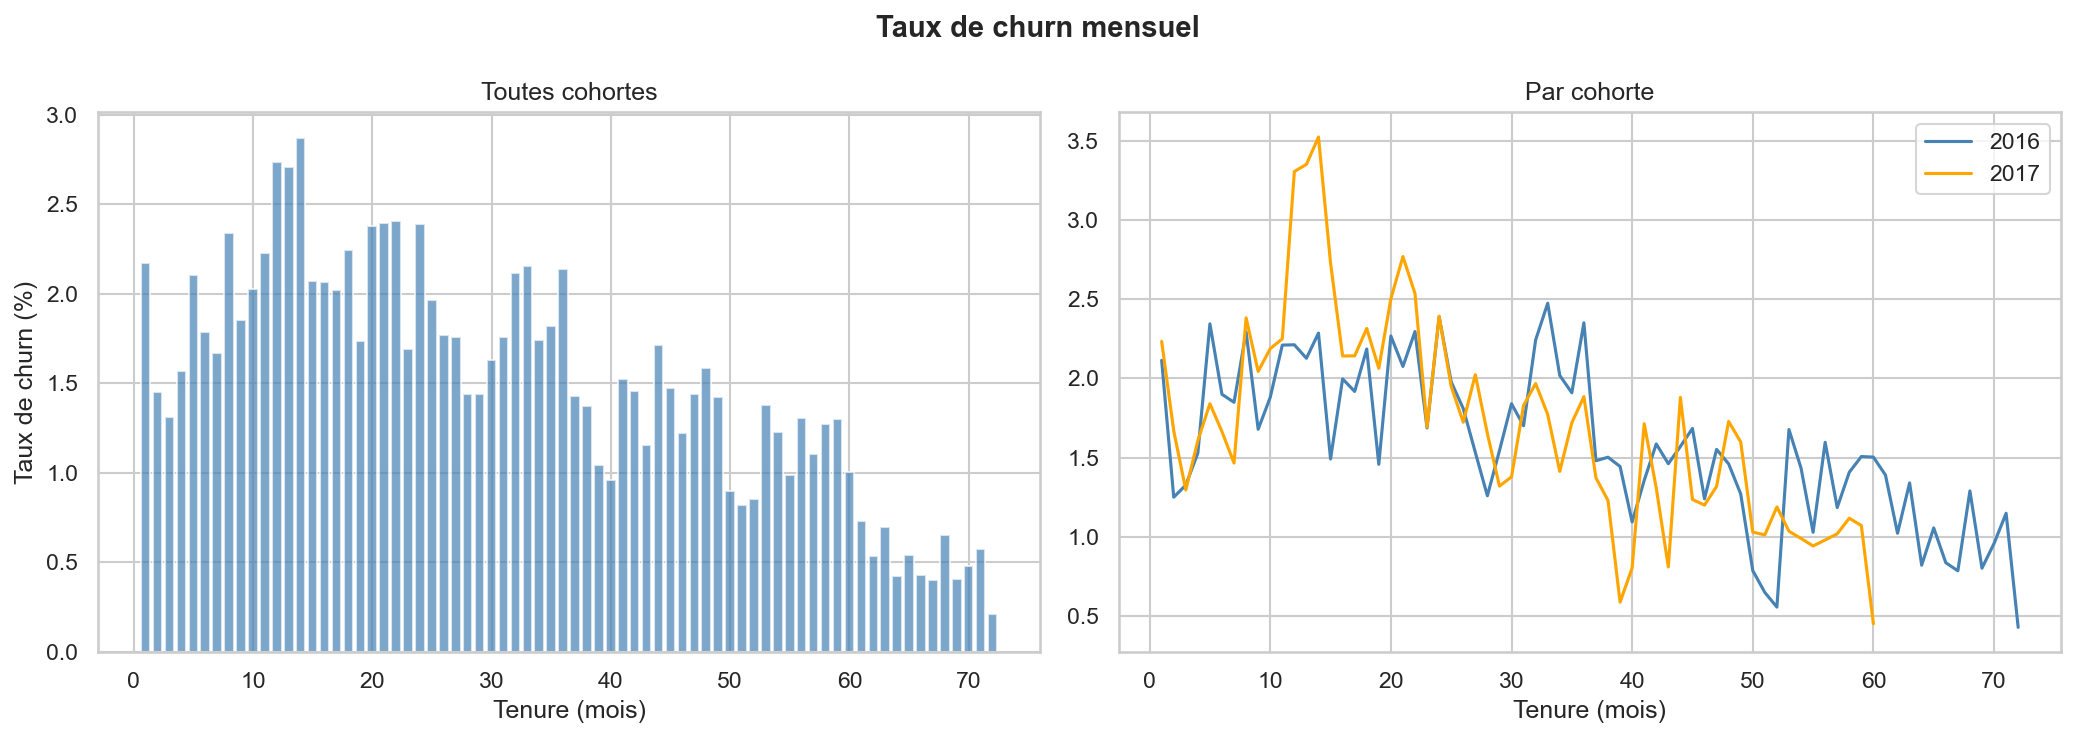

In [40]:
# 5. CHURN — Q3 : Taux de churn mensuel

def monthly_churn_rate(sub_df):
    """Taux de churn = churners au mois t / survivants fin t-1."""
    max_t = int(sub_df['duration'].max())
    rates = []
    for t in range(1, max_t + 1):
        at_risk  = ((~sub_df['churned']) | (sub_df['duration'] >= t)).sum()
        churned_t = (sub_df['churned'] & (sub_df['duration'] == t)).sum()
        if at_risk == 0:
            break
        rates.append({'tenure': t, 'churn_rate': churned_t / at_risk * 100})
    return pd.DataFrame(rates)

rates_all  = monthly_churn_rate(df)
rates_2016 = monthly_churn_rate(df[df['cohort'] == '2016'])
rates_2017 = monthly_churn_rate(df[df['cohort'] == '2017'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Taux de churn mensuel", fontsize=14, fontweight='bold')

axes[0].bar(rates_all['tenure'], rates_all['churn_rate'], color='steelblue', alpha=0.7)
axes[0].set(title='Toutes cohortes', xlabel='Tenure (mois)', ylabel='Taux de churn (%)')

axes[1].plot(rates_2016['tenure'], rates_2016['churn_rate'], label='2016', color='steelblue')
axes[1].plot(rates_2017['tenure'], rates_2017['churn_rate'], label='2017', color='orange')
axes[1].set(title='Par cohorte', xlabel='Tenure (mois)')
axes[1].legend()

plt.tight_layout()
plt.show()


Facture moyenne globale : 1612 €

cohort
2016    1750.0
2017    1462.0
Name: facture_moyenne, dtype: float64
fiber_or_adsl
adsl     1390.0
fiber    2288.0
Name: facture_moyenne, dtype: float64
sub_offer
11.4:Freebox Revolution with TV 3999eur                        1879.0
8.2:Freebox Revolution 2999eur                                 1183.0
8.57:Freebox Revolution 2999eur | Promo : 999eur for 1 year     678.0
Name: facture_moyenne, dtype: float64


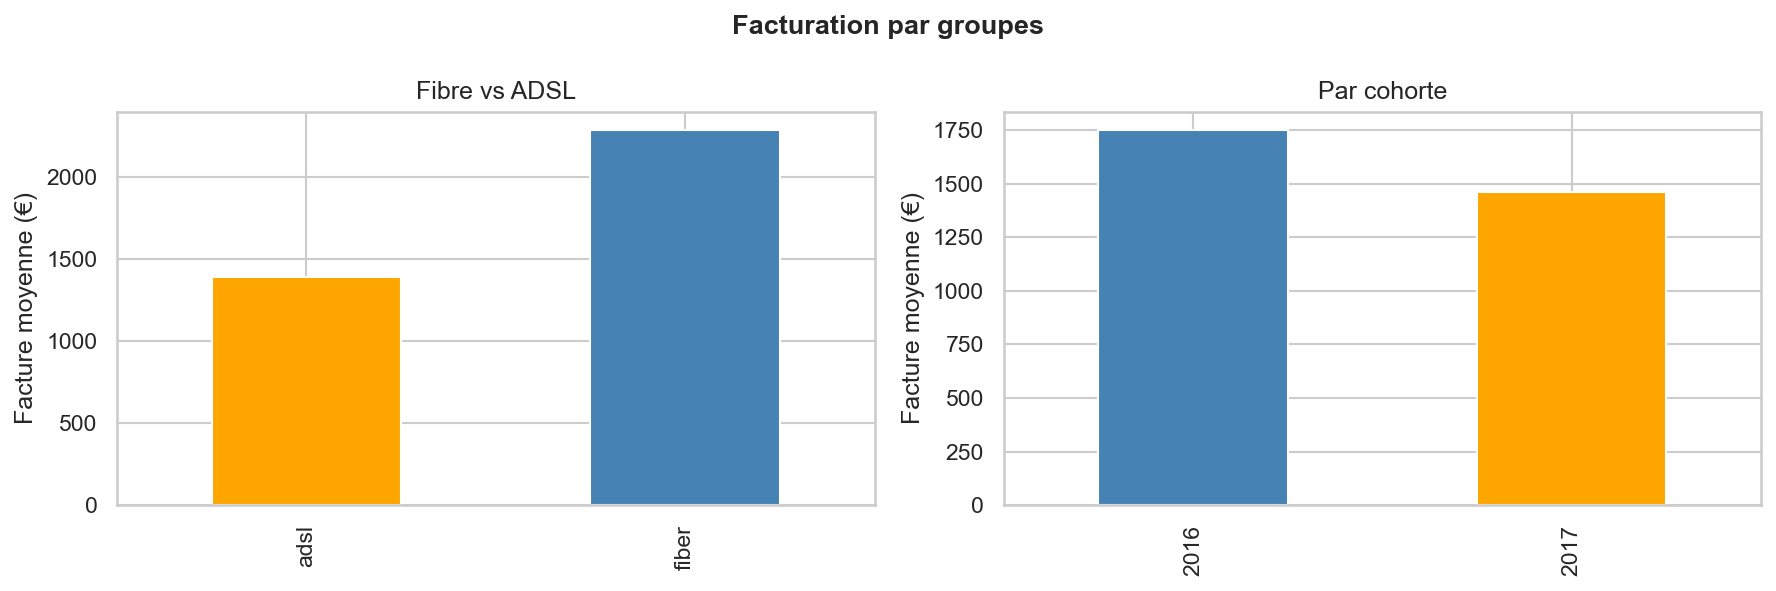

In [46]:
# 6. BILLING — Q1 : Facture moyenne par groupe

print(f"\nFacture moyenne globale : {df['total_bill'].mean():.0f} €\n")
print(df.groupby('cohort')['total_bill'].mean().rename('facture_moyenne').round(0))
print(df.groupby('fiber_or_adsl')['total_bill'].mean().rename('facture_moyenne').round(0))
print(df.groupby('sub_offer')['total_bill'].mean().rename('facture_moyenne').round(0))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Facturation par groupes", fontsize=13, fontweight='bold')

df.groupby('fiber_or_adsl')['total_bill'].mean().plot.bar(ax=axes[0], color=['orange','steelblue'])
axes[0].set(title='Fibre vs ADSL', ylabel='Facture moyenne (€)', xlabel='')

df.groupby('cohort')['total_bill'].mean().plot.bar(ax=axes[1], color=['steelblue','orange'])
axes[1].set(title='Par cohorte', ylabel='Facture moyenne (€)', xlabel='')

plt.tight_layout()
plt.show()

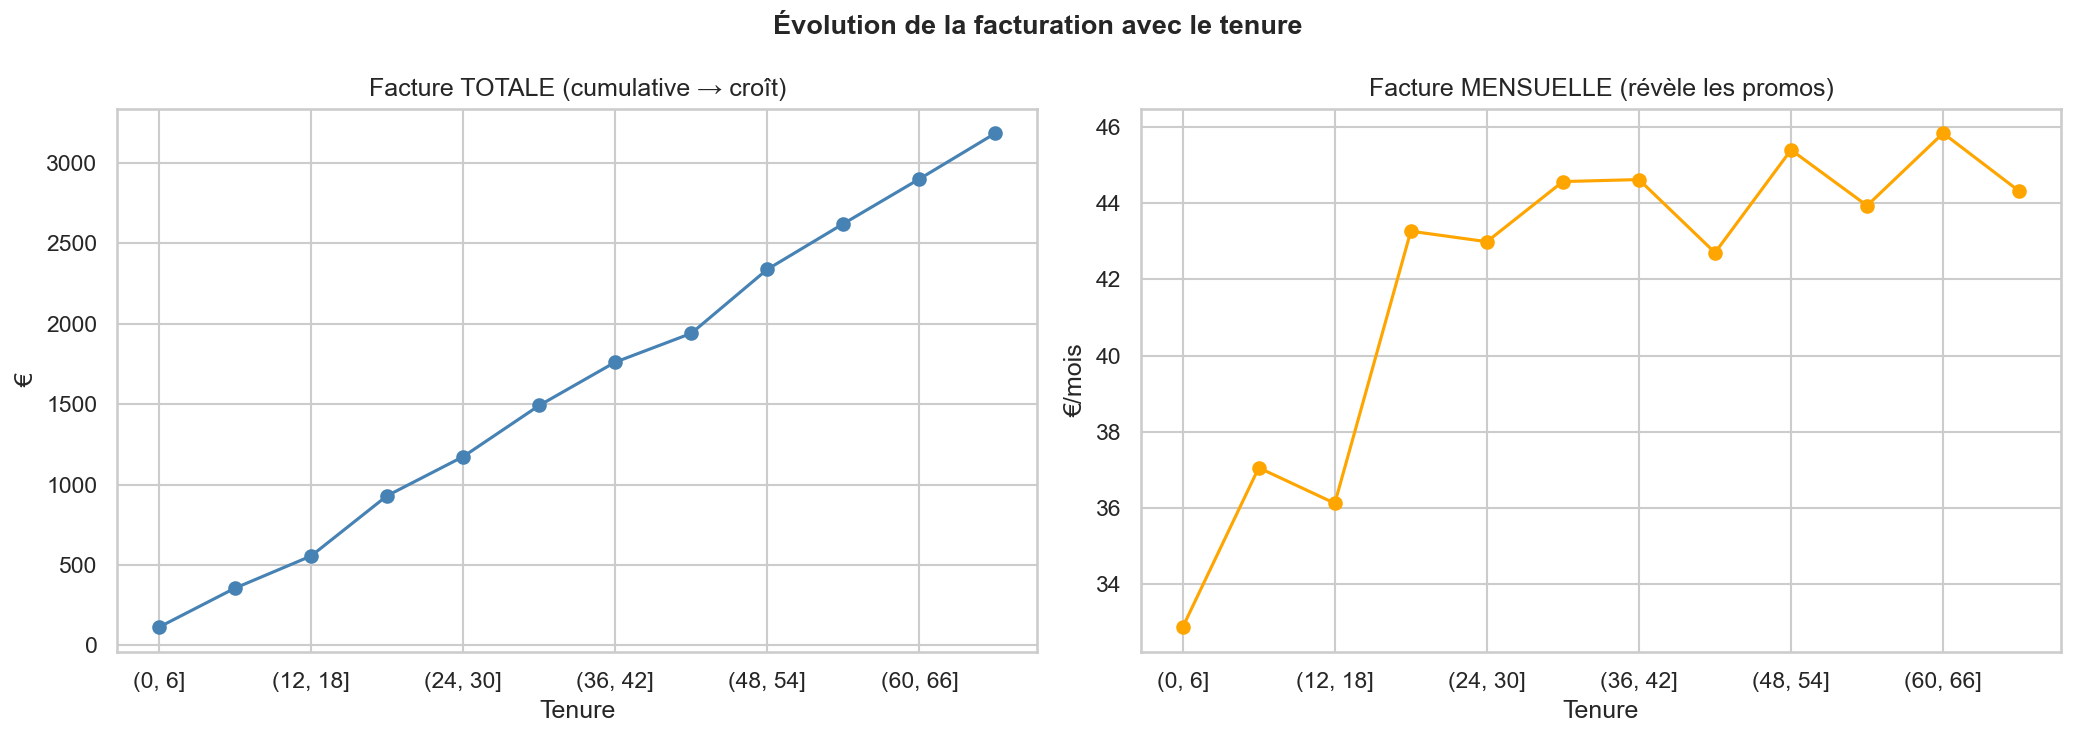

In [47]:
# 7. BILLING — Q2 : Evolution avec le tenure

df['monthly_bill'] = df['total_bill'] / df['duration']

# Tranches de 6 mois sans observed dans pd.cut()
df['tenure_bucket'] = pd.cut(df['duration'], bins=range(0, 85, 6))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Évolution de la facturation avec le tenure", fontsize=13, fontweight='bold')

df.groupby('tenure_bucket', observed=True)['total_bill'].mean().plot(ax=axes[0], marker='o', color='steelblue')
axes[0].set(title='Facture TOTALE (cumulative → croît)', xlabel='Tenure', ylabel='€')

df.groupby('tenure_bucket', observed=True)['monthly_bill'].mean().plot(ax=axes[1], marker='o', color='orange')
axes[1].set(title='Facture MENSUELLE (révèle les promos)', xlabel='Tenure', ylabel='€/mois')

plt.tight_layout()
plt.show()

               n_users  churn_rate  avg_bill  avg_duration
has_retention                                             
False            19491        68.0    1589.0          36.0
True               509        26.0    2517.0          62.0


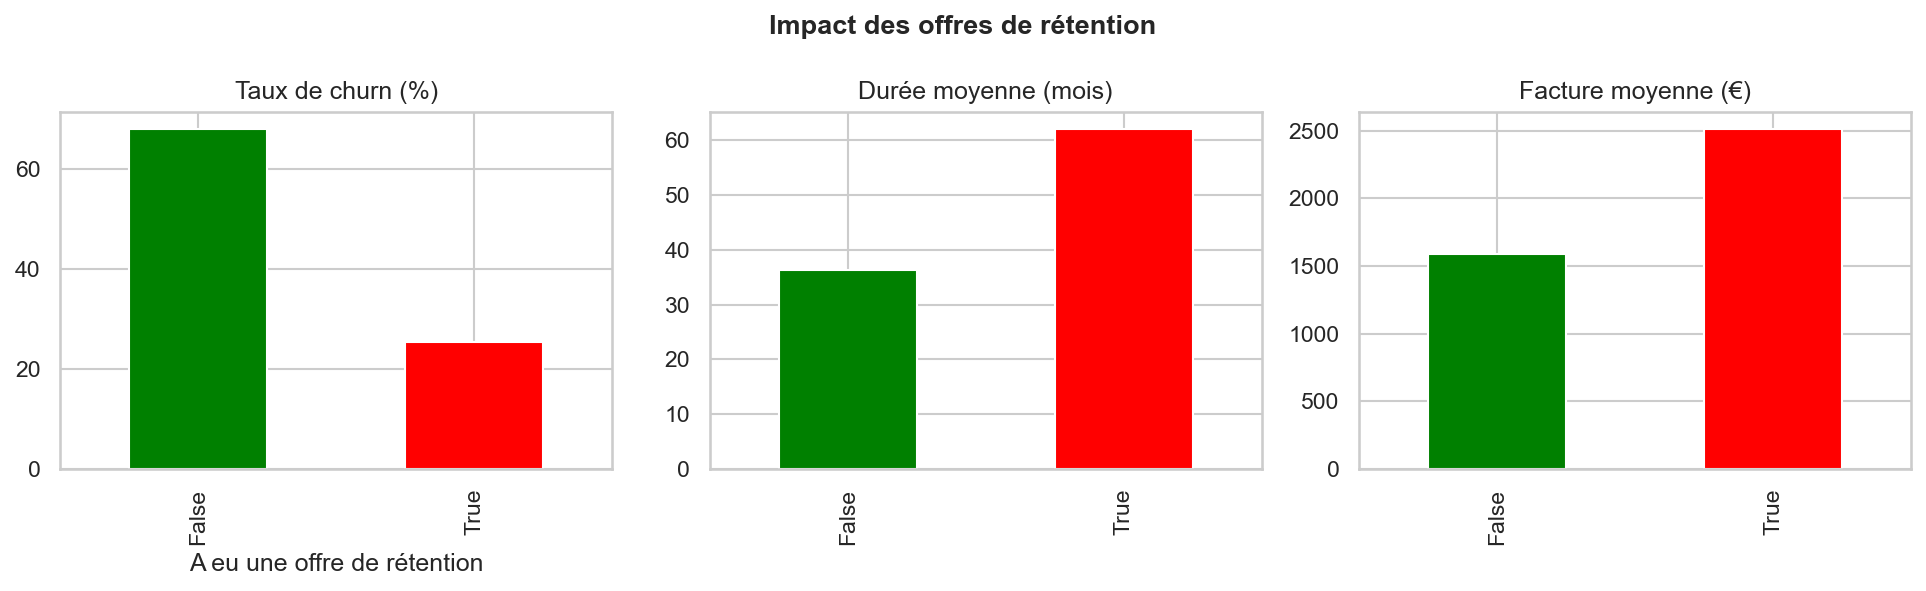

In [43]:
# 8. ANALYSE COMPLÉMENTAIRE : IMPACT DE =LA RÉTENTION

ret = df.groupby('has_retention').agg(
    n_users=('churned', 'count'),
    churn_rate=('churned', 'mean'),
    avg_bill=('total_bill', 'mean'),
    avg_duration=('duration', 'mean')
)
ret['churn_rate'] = (ret['churn_rate'] * 100).round(1)
print(ret.round(0))

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
fig.suptitle("Impact des offres de rétention", fontsize=13, fontweight='bold')

colors = ['green', 'red']
ret['churn_rate'].plot.bar(ax=axes[0], color=colors)
axes[0].set(title='Taux de churn (%)', xlabel='A eu une offre de rétention')

ret['avg_duration'].plot.bar(ax=axes[1], color=colors)
axes[1].set(title='Durée moyenne (mois)', xlabel='')

ret['avg_bill'].plot.bar(ax=axes[2], color=colors)
axes[2].set(title='Facture moyenne (€)', xlabel='')

plt.tight_layout()
plt.show()


ROC-AUC : 0.743


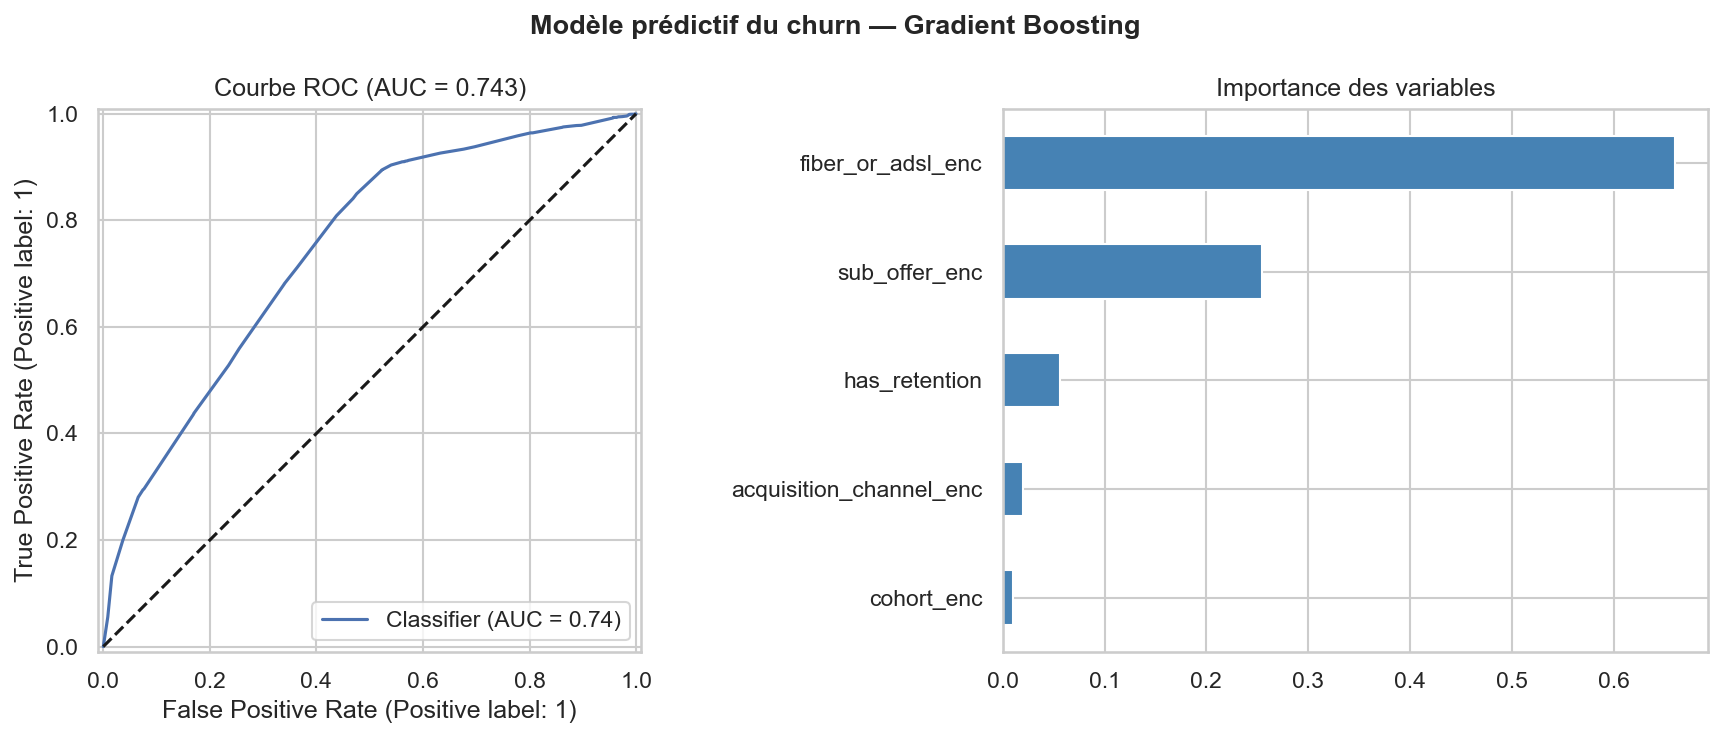

In [44]:
# 9. MODÈLE PRÉDICTIF DU CHURN

# Encodage des variables catégorielles
le = LabelEncoder()
for col in ['fiber_or_adsl', 'cohort', 'acquisition_channel', 'sub_offer']:
    df[col + '_enc'] = le.fit_transform(df[col])

FEATURES = ['fiber_or_adsl_enc', 'cohort_enc', 'acquisition_channel_enc',
            'sub_offer_enc', 'has_retention']
TARGET = 'churned'

X = df[FEATURES].astype(float)
y = df[TARGET].astype(int)

# Split 80/20 stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entraînement Gradient Boosting
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05,
                                   max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Évaluation
y_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC : {auc:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Modèle prédictif du churn — Gradient Boosting", fontsize=13, fontweight='bold')

# Courbe ROC
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_title(f'Courbe ROC (AUC = {auc:.3f})')

# Feature importances
feat_imp = pd.Series(model.feature_importances_, index=FEATURES).sort_values()
feat_imp.plot.barh(ax=axes[1], color='steelblue')
axes[1].set_title('Importance des variables')

plt.tight_layout()
plt.show()